In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time
from glob import glob


/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [3]:
client = Client(processes=False)
client

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34679 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.8.216.13:34679/status,
Dashboard: http://128.8.216.13:34679/status,Workers: 1
Total threads: 128,Total memory: 503.40 GiB
Status: running,Using processes: False
Comm: inproc://128.8.216.13/55382/1,Workers: 1
Dashboard: http://128.8.216.13:34679/status,Total threads: 128
Started: Just now,Total memory: 503.40 GiB
Comm: inproc://128.8.216.13/55382/4,Total threads: 128
Dashboard: http://128.8.216.13:33477/status,Memory: 503.40 GiB
Nanny: None,


In [4]:

def loadNewRun(filename, chunks, avg=False):
    # note here that filename should be the directory of history files
    from glob import glob

    
    if avg:
        files = sorted(glob(filename+'jet_avg.*.nc'))
    else:
        files = sorted(glob(filename+'jet_his.*.nc'))
    dsWC = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)

    ds = xr.open_dataset('../data/model/jet_his.nc')

    # For some reason I have to correct the grid metrics that aren't being output with this CROCO run.
    #dsWC['s_rho'] = ('s_rho', ds.s_rho)
    #dsWC['s_w'] = ('s_w', ds.s_w)
    #dsWC['Cs_r'] = ds.Cs_r
    #dsWC['Cs_w'] = ds.Cs_w
    #dsWC['h'] = (('eta_rho', 'xi_rho'), 4000  + 0*dsWC.zeta.isel(time=0))
    #dsWC['pm'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.zeta.isel(time=0))
    #dsWC['pn'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.zeta.isel(time=0))
    #dsWC['pm_u'] = (('eta_rho', 'xi_u'), 1/500 + 0*dsWC.u.isel(time=0, s_rho=0))
    #dsWC['pn_v'] = (('eta_v', 'xi_rho'), 1/500 + 0*dsWC.v.isel(time=0, s_rho=0))

    #dsWC['f'] = dsNC.f ## XXX THIS IS A HACK THAT WON"T ALWAYS WORK
    #dsWC = dsWC.rename(time='ocean_time')
    print('here')
    dsWC, grid = xroms.roms_dataset(dsWC, Vtransform=1) ### IS THIS CORRECT???? NEED TO VERIFY!!
    print('and here')
    dsWC['rho'] = dsWC.temp
    dsWC = dsWC.swap_dims({'time':'ocean_time'})
    dsWC['temp'] = (-(1000+dsWC.rho)/(1000+dsWC.rho.isel(ocean_time=1, s_rho=-1).mean()) + 1)/2e-4 + 20
    return dsWC, grid

In [5]:
reload(lruns)
dsOLD, gridOLD = lruns.loadRun('../data/model/jet_his_20_NC.nc', chunks={'time':1}, old=True)
dsOLD

chunks = {'time':1}
#dsWC, gridWC = lruns.loadZarrRun('../data/interim/dst.zarr')
# dsWC, gridWC = lruns.loadNewRun('../data/model/JET_NML_CFB_AVG/', chunks=chunks,  avg=False)
#dsWC['f'] = dsOLD.f

runname = 'JET_NML_CFB_EKE'
dsWC, gridWC = loadNewRun('../data/model/'+runname+'/', chunks=chunks, avg=True)
dsWC

runname = 'JET_NML_NOCFB_EKE'
dsNC, gridNC = loadNewRun('../data/model/'+runname+'/', chunks=chunks, avg=True)
dsNC

dsWC

here
and here
here
and here


<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001,
                 s_rho: 100, s_w: 101, ocean_time: 8, auxil: 4)
Coordinates: (12/25)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(100, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(100, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(101, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(101, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(101, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: ocean_time, auxil
Data variables: (12/69)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    ...          ...
    dV_v        (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
    dV_w_v      (ocean_time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(1, 101, 4001, 1002), meta=np.ndarray>
    dV_psi      (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 100, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (ocean_time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(1, 101, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
Attributes: (12/56)
    type:          CROCO averages file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.00000.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [24]:
dsWC_PVF = xr.open_mfdataset('../data/model/JET_NML_CFB_EKE/jet_pv*', chunks=chunks)
dsWC_PVF

dsNC_PVF = xr.open_mfdataset('../data/model/JET_NML_NOCFB_EKE/jet_pv*', chunks=chunks)
dsNC_PVF

<xarray.Dataset>
Dimensions:       (time: 9, auxil: 4, s_rho: 100, eta_rho: 4002, xi_rho: 1002,
                   xi_u: 1001, eta_v: 4001)
Coordinates:
  * time          (time) float64 3.119e+07 3.128e+07 ... 3.18e+07 3.188e+07
Dimensions without coordinates: auxil, s_rho, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    time_step     (time, auxil) int32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    scrum_time    (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    temp_rhs      (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
    u_vmix_trans  (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 100, 4002, 1001), meta=np.ndarray>
    v_vmix_trans  (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
    u_rhs         (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 100, 4002, 1001), meta=np.ndarray>
    v_rhs         (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
Attributes: (12/55)
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.00000.nc
    skpp:          2005
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [27]:
ny = np.array(dsWC.eta_rho.size)
nyc = int(ny/2)
nysp = int(ny/16)
yN = ny-nysp
yS = nysp
yl = slice(yS, yN)

zl = slice(50, 100)

yl

slice(250, 3752, None)

In [36]:
# Calculate PV fluxes

def DiabaticPVFlux(slevel, yl):
    Db = 9.8*dspv.temp_rhs.isel( s_rho=slevel)/dst.rho0
    uy = xroms.to_rho(grid.derivative(dst.u.isel(s_rho=slevel), 'Y'), grid)
    vx = xroms.to_rho(grid.derivative(dst.v.isel(s_rho=slevel), 'X'), grid)

    omega_z =  vx - uy +  dst.f#xroms.to_rho(dst.xroms.vort, grid) # this is on a s_w grid...?
    print()
    D = -omega_z*Db
    print(D)
    Di = (D * dst.dx*dst.dy).isel(eta_rho=yl).sum(('eta_rho', 'xi_rho'))
    return Di.compute()

dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridWC
dspv = dsWC_PVF
#dst['time'] =dspv.time # Hack necessary to align outputs...

DSurf = DiabaticPVFlux(-1, yl)

<xarray.DataArray (time: 8, eta_rho: 4002, xi_rho: 1002)>
dask.array<add, shape=(8, 4002, 1002), dtype=float32, chunksize=(1, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * time     (time) float64 3.115e+07 3.123e+07 ... 3.167e+07 3.175e+07
    x_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
<xarray.DataArray (time: 0, eta_rho: 4002, xi_rho: 1002)>
dask.array<mul, shape=(0, 4002, 1002), dtype=float64, chunksize=(0, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
    x_rho    (eta_rho, xi_rho) float32 dask.array<chu

In [32]:
dst

<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001,
                 s_rho: 100, s_w: 101, time: 8, auxil: 4)
Coordinates: (12/25)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(100, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(100, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(101, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(101, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(101, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/69)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    ...          ...
    dV_v        (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
    dV_w_v      (time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(1, 101, 4001, 1002), meta=np.ndarray>
    dV_psi      (time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 100, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(1, 101, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
Attributes: (12/56)
    type:          CROCO averages file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.00000.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [33]:
def FrictionalPVFlux(slevel):
    
    buoyancy = xroms.buoyancy(dst.rho, dst.rho0)
    by = xroms.to_rho(grid.derivative(buoyancy, 'Y'), grid).isel(s_rho=slevel)
    bx = xroms.to_rho(grid.derivative(buoyancy, 'X'), grid).isel(s_rho=slevel)
    
    Fx = xroms.to_rho(dspv.isel( s_rho=slevel).u_rhs, grid)
    Fy = xroms.to_rho(dspv.isel( s_rho=slevel).v_rhs, grid)
    
    FricFlux = bx*Fy - by*Fx
    
    FricFluxi = (FricFlux *dst.dx*dst.dy).isel(eta_rho=yl).sum(('eta_rho', 'xi_rho'))
    #print(FricFluxi)
    return FricFluxi.compute()

dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridWC
dspv = dsWC_PVF
# dst['time'] =dspv.time # Hack necessary to align outputs...

FFsurf = FrictionalPVFlux(-1)

In [34]:
FFsurf

<xarray.DataArray (time: 8)>
array([-0.01653322, -0.02212846, -0.02352497, -0.02302287, -0.02180696,
       -0.02116507, -0.02131844, -0.02175415])
Coordinates:
    s_rho    float32 -0.005
  * time     (time) float64 3.115e+07 3.123e+07 ... 3.167e+07 3.175e+07

In [61]:
DSurfi = integrate.cumtrapz(DSurf, x=dspv.time, initial=0)
DSurfi

FSurfi = integrate.cumtrapz(FFsurf, x=dspv.time, initial=0)
FSurfi

array([      0.        ,   -2995.97285263,   -5581.84365651,
         -8330.20480966,  -11080.32920454,  -13804.816499  ,
        -16531.62295973,  -19313.70888084,  -22132.11128624,
        -24927.60227145,  -27634.25918327,  -30261.16161314,
        -32908.67635408,  -35642.10772226,  -38477.32379227,
        -41351.34939808,  -44250.54857828,  -47181.84498016,
        -50138.45403692,  -53158.61606139,  -56222.84022188,
        -59306.24734951,  -62438.13610805,  -65567.58846622,
        -68686.32260056,  -71780.024005  ,  -74798.25258064,
        -77752.32269817,  -80628.64369386,  -83451.6857491 ,
        -86282.66058096,  -89121.29733121,  -91880.7159467 ,
        -94496.39918674,  -97030.26452475,  -99547.88691567,
       -102067.02892584, -104625.8340264 , -107169.35270781,
       -109657.40840976, -112111.88961177, -114540.05410875,
       -116940.04592932, -119380.77480433, -121875.37470933])

2022-08-03 14:43:00,082 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


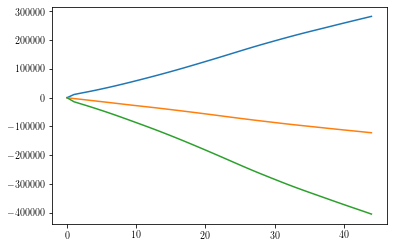

2022-08-03 14:43:05,385 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-08-03 14:43:10,062 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-08-03 14:43:15,440 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-08-03 14:43:20,619 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-08-03 14:43:25,897 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [65]:
plt.plot(-DSurfi)
plt.plot(FSurfi)
plt.plot(-DSurfi + FSurfi)

In [8]:
#dsPV, gridPV = lruns.loadRun('../data/interim/pvfiles', chunks = chunks, old=False)

files = sorted(glob('../data/interim/pv_nml_cfb_avg/pv*.nc'))
dsPV = xr.open_mfdataset(files[1:], combine='nested',concat_dim='time', chunks={'s_rho':5})
dsPV

<xarray.Dataset>
Dimensions:  (time: 12, s_rho: 100, eta_rho: 4002, xi_rho: 1002)
Coordinates:
  * time     (time) float64 3.123e+07 3.132e+07 3.141e+07 ... 3.417e+07 3.46e+07
  * s_rho    (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
    x_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
Data variables:
    ertel    (time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>

In [16]:
# Volume integrate the PV
volPV = dsPV.ertel*dsWC.dx*dsWC.dy*dsWC.dz0

In [19]:
yl = slice(500, 3500)
zl = slice(50, 100)
PV_SERIES = volPV.isel(eta_rho=yl, s_rho=zl).sum(('s_rho', 'eta_rho', 'xi_rho')).compute()

In [1]:
plt.plot(dsPV.time, PV_SERIES-PV_SERIES[0])
plt.plot(dspv.time, (FSurfi-DSurfi))

NameError: name 'plt' is not defined

In [ ]:
def calcIntPV(ds, grid, el=[0,-1], sl = [0,-1]):
    rhotob = -9.8/1020
    
    vx = xroms.to_rho(grid.derivative(ds.v, 'X'),grid)
    #vx = xroms.hgrad(
    #    ds.v,
    #    grid,
    #    which ='xi',
    #    hboundary='extend',
    #    hfill_value=None,
    #    sboundary = 'extend',
    #    sfill_value=None,
    #    hcoord='rho',
    #    scoord='s_rho')
    uy = xroms.to_rho(grid.derivative(ds.u, 'Y'),grid)
    #uy = xroms.hgrad(
    #    ds.u,
    #    grid,
    #    which ='eta',
    #    hboundary='extend',
    #    hfill_value=None,
    #    sboundary = 'extend',
    #    sfill_value=None, 
    #    hcoord='rho',
    #    scoord='s_rho')
    #vz = xroms.to_rho(grid.interp(grid.derivative(ds.v, 'Z', boundary='extend'),'Z',to='center', boundary='extend'),grid)
    uz = xroms.to_rho(grid.interp(grid.derivative(ds.u, 'Z', boundary='extend'),'Z',to='center', boundary='extend'),grid)
    #uz = xroms.ddz(
    #        ds.u,
    #        grid,
    #        hcoord='rho',
    #        scoord='s_rho',
    #        hboundary = 'extend',
    #        sboundary = 'extend',
    #        hfill_value= None,
    #        sfill_value= None)
    #termy = grid.integrate(((rhotob*ds.rho*uz).isel(eta_rho=-1) - (rhotob*ds.rho*uz).isel(eta_rho=0)), ('xi_rho','Z'))
    #termz = grid.integrate(((rhotob*ds.rho*(ds.f + vx - uy)).isel(s_rho=-1) 
    #                        - (rhotob*ds.rho*(ds.f + vx - uy)).isel(s_rho=0)), ('X', 'Y'))
    ei = el[-1]
    face1 = (rhotob*ds.rho.isel(eta_rho=ei)*uz.isel(eta_rho=ei)*ds.dz.isel(eta_rho=ei)*ds.dx.isel(eta_rho=ei)).sum(('xi_rho', 's_rho'))
    ei = el[0]
    face2 = (rhotob*ds.rho.isel(eta_rho=ei)*uz.isel(eta_rho=ei)*ds.dz.isel(eta_rho=ei)*ds.dx.isel(eta_rho=ei)).sum(('xi_rho', 's_rho'))
    termy = face1 - face2
    
    si = sl[-1]
    face1 = (rhotob*ds.rho.isel(s_rho=si)*(ds.f+vx.isel(s_rho=si)-uy.isel(s_rho=si))*ds.dx*ds.dy).isel(eta_rho=slice(el[0], el[-1])).sum(('xi_rho','eta_rho'))
    si = sl[0]
    face2 = (rhotob*ds.rho.isel(s_rho=si)*(ds.f+vx.isel(s_rho=si)-uy.isel(s_rho=si))*ds.dx*ds.dy).isel(eta_rho=slice(el[0], el[-1])).sum(('xi_rho','eta_rho'))

    termz = face1-face2
    return termy + termz

el = [250, 3750]
el = [0, -1]
sl = [0, -1]
dst = dsOLD
grid = gridOLD
#dst = dst.swap_dims({'ocean_time':'time'}) # Need for new runs
PVWC = calcIntPV(dst, grid, el=el, sl=sl)
PVWC = PVWC.swap_dims({'ocean_time':'time'})
PVWC

In [ ]:
PV_SERIES_DIR = PVWC.isel(time = range(0, 40, 5)).compute()

In [ ]:
plt.plot(PVWC.time.isel(time=range(0, 40, 5)), PV_SERIES_DIR - PV_SERIES_DIR[1], marker='.')
#plt.plot(dsPV.time, PV_SERIES-PV_SERIES[0], marker='.')

In [ ]:
buoyancy = xroms.buoyancy(dsWC.rho, rho0=dsWC.rho0)
plt.plot(buoyancy.isel(ocean_time=-1, eta_rho=1000, xi_rho=0), dsWC.z_rho0.isel(eta_rho=1000, xi_rho=0))

In [ ]:
plt.rcParams['text.usetex'] = False
dsPV.ertel.isel(time=0, xi_rho=0, s_rho=slice(50,100)).plot()

In [ ]:
yl


In [ ]:
plt.plot(buoyancy.isel(ocean_time=-1, s_rho=-1, xi_rho=0))


In [ ]:
dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridWC
dzdz =  grid.derivative(dst.z_rho, "Z", boundary='fill', fill_value=20).isel(time=0, eta_rho=0, xi_rho=0)
dzdz


In [ ]:
dzdz.values

In [ ]:
dzdz.values[0] + dzdz.values[-1]

In [ ]:
dst.dz.isel(time=0, eta_rho=0, xi_rho=0).values

## COMPARE TWO RUNS

In [10]:
def FrictionalPVFlux(slevel):
    
    buoyancy = xroms.buoyancy(dst.rho, dst.rho0)
    by = xroms.to_rho(grid.derivative(buoyancy, 'Y'), grid).isel(s_rho=slevel)
    bx = xroms.to_rho(grid.derivative(buoyancy, 'X'), grid).isel(s_rho=slevel)
    
    Fx = xroms.to_rho(dspv.isel( s_rho=slevel).u_rhs, grid)
    Fy = xroms.to_rho(dspv.isel( s_rho=slevel).v_rhs, grid)
    
    FricFlux = bx*Fy - by*Fx
    
    FricFluxi = (FricFlux *dst.dx*dst.dy).isel(eta_rho=yl).sum(('eta_rho', 'xi_rho'))
    #print(FricFluxi)
    return FricFluxi.compute()

yl = slice(500, 3500)

dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridWC
dspv = dsWC_PVF

fpv_WC = FrictionalPVFlux(-1)
print('1 done')
dst = dsNC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridNC
dspv = dsNC_PVF

fpv_NC = FrictionalPVFlux(-1)



1 done


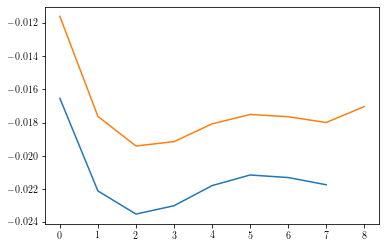

In [12]:
plt.plot(fpv_WC)
plt.plot(fpv_NC)

In [15]:


yl = slice(500, 3500)

dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridWC
dspv = dsWC_PVF

dpv_WC = DiabaticPVFlux(-1, yl).compute()
print('1 done')
dst = dsNC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridNC
dspv = dsNC_PVF

dpv_NC = DiabaticPVFlux(-1, yl).compute()



<xarray.DataArray (time: 0, eta_rho: 4002, xi_rho: 1002)>
dask.array<mul, shape=(0, 4002, 1002), dtype=float64, chunksize=(0, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
Attributes:
    long_name:  right hand side
    units:      Celsius second-1
    field:      
1 done
<xarray.DataArray (time: 0, eta_rho: 4002, xi_rho: 1002)>
dask.array<mul, shape=(0, 4002, 1002), dtype=float64, chunksize=(0, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
Attributes:
    long_name:  right hand side
    units:      Celsius second-1
    field:      


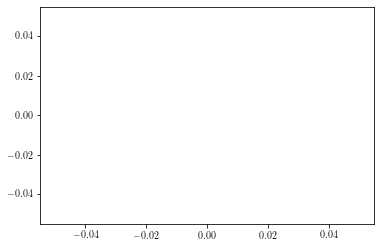

In [16]:
plt.plot(dpv_WC)
plt.plot(dpv_NC)

In [35]:
dsWC['buoyancy'] = xroms.buoyancy(dsWC.rho, 1020)
PVWC=dsWC.isel(ocean_time=-1).xroms.ertel.sum().values
PVWC0=dsWC.isel(ocean_time=0).xroms.ertel.sum().values


In [33]:
dsNC['buoyancy'] = xroms.buoyancy(dsNC.rho, 1020)
PVNC = dsNC.isel(ocean_time=-1).xroms.ertel.sum().values

In [34]:
PVWC - PVNC

0.0027099252

In [36]:
PVWC - PVWC0

-0.008368611

In [72]:

def DiabaticPVFlux(slevel, yl):
    Db = 9.8*dspv.temp_rhs.isel( s_rho=slevel)/dst.rho0
    uy = xroms.to_rho(grid.derivative(dst.u.isel(s_rho=slevel), 'Y'), grid)
    vx = xroms.to_rho(grid.derivative(dst.v.isel(s_rho=slevel), 'X'), grid)

    omega_z =  vx - uy +  dst.f#xroms.to_rho(dst.xroms.vort, grid) # this is on a s_w grid...?
    print(omega_z)
    print(Db)
    D = -omega_z*Db
    print(D)
    Di = (D * dst.dx*dst.dy).isel(eta_rho=yl).sum(('eta_rho', 'xi_rho'))
    return Di.compute()

dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridWC
dspv = dsWC_PVF
dspv['time'] =dst.time # HACK
#dst['time'] =dspv.time # Hack necessary to align outputs...

DSurfWC = DiabaticPVFlux(-1, yl)

dst = dsNC
dst = dst.swap_dims({'ocean_time':'time'})
grid = gridNC
dspv = dsNC_PVF
dspv['time'] =dst.time
#dst['time'] =dspv.time # Hack necessary to align outputs...

DSurfNC = DiabaticPVFlux(-1, yl)
DSurfNC

<xarray.DataArray (time: 8, eta_rho: 4002, xi_rho: 1002)>
dask.array<add, shape=(8, 4002, 1002), dtype=float32, chunksize=(1, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * time     (time) float64 3.115e+07 3.123e+07 ... 3.167e+07 3.175e+07
    x_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
<xarray.DataArray (time: 8, eta_rho: 4002, xi_rho: 1002)>
dask.array<truediv, shape=(8, 4002, 1002), dtype=float64, chunksize=(1, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 3.115e+07 3.123e+07 ... 3.167e+07 3.175e+07
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  right hand side
    units:      Celsius second-1
    field:      
<xarray.DataArray (

<xarray.DataArray (time: 9)>
array([-0.06790836, -0.0635812 , -0.06292504, -0.06663195, -0.0716341 ,
       -0.07462577, -0.07784296, -0.08192089, -0.08503131])
Coordinates:
  * time     (time) float64 3.115e+07 3.123e+07 ... 3.175e+07 3.184e+07

In [68]:
dst.time[0] - dspv.time[0]+86340/2

<xarray.DataArray 'time' ()>
array(0.)
Attributes:
    long_name:      averaged time since initialization
    units:          second
    field:          time, scalar, series
    standard_name:  time
    axis:           T

<xarray.DataArray 'time' ()>
array(31190400.)
Coordinates:
    time     float64 3.119e+07
Attributes:
    long_name:      time since initialization
    units:          second
    field:          time, scalar, series
    standard_name:  time
    axis:           T

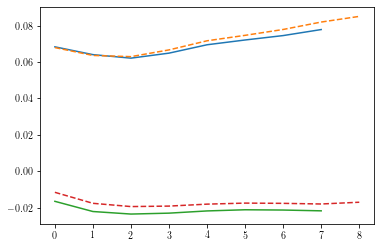

In [76]:
plt.plot(-DSurfWC)
plt.plot(-DSurfNC, linestyle='--')
plt.plot(fpv_WC)
plt.plot(fpv_NC, linestyle='--')

In [75]:
dsWC_PVF.time[0] - dsWC.ocean_time[0]

<xarray.DataArray ()>
array(31147230.)
Coordinates:
    time     float64 3.115e+07
Attributes:
    long_name:      averaged time since initialization
    units:          second
    field:          time, scalar, series
    standard_name:  time
    axis:           T

In [78]:
dsWC.isel(.xroms.ertel

ValueError: ('s_w', 'eta_rho', 'xi_rho') must be a permuted list of ('s_w', 'eta_rho', 'xi_rho', 'ocean_time'), unless `...` is included

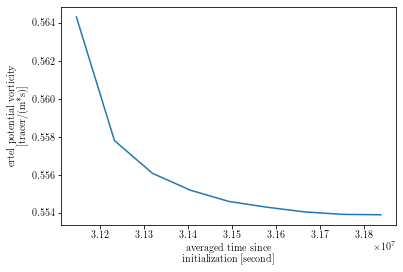

In [83]:
dst.xroms.ertel.sum(('s_rho', 'eta_rho', 'xi_rho')).plot()

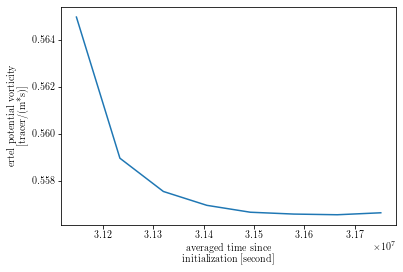

In [84]:
dst = dsWC
dst = dst.swap_dims({'ocean_time':'time'})
dst.xroms.ertel.sum(('s_rho', 'eta_rho', 'xi_rho')).plot()